# Visualización de máquinas inteligentes 
## Tema: Problema de sesgo y varianza
### Subtema: Problema de sesgo y varianza

In [89]:
# Importar paquetes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *

seed = 20210719

In [90]:
# Instalar última versión de yellowbrick y sklearn
!pip install yellowbrick==1.3.post1
!pip install scikit-learn==0.24.2

You should consider upgrading via the '/Users/dantegruizmartinez/.pyenv/versions/3.8.0/envs/diplomado/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/dantegruizmartinez/.pyenv/versions/3.8.0/envs/diplomado/bin/python3.8 -m pip install --upgrade pip' command.


In [91]:
# Crear carpeta para las imágenes
import os

if not os.path.exists("figs"):
    print("El directorio de fig ha sido creado.")
    os.mkdir("figs")
    os.mkdir("figs/aprende")
    
path_figs = 'figs/aprende/'

* CRIM - per capita crime rate by town
* ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
* INDUS - proportion of non-retail business acres per town.
* CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
* NOX - nitric oxides concentration (parts per 10 million)
* RM - average number of rooms per dwelling
* AGE - proportion of owner-occupied units built prior to 1940
* DIS - weighted distances to five Boston employment centres
* RAD - index of accessibility to radial highways
* TAX - full-value property-tax rate per 10,000 USD
* PTRATIO - pupil-teacher ratio by town
* B-1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
* LSTAT - % lower status of the population
* MEDV - Median value of owner-occupied homes in 1000's USD

In [92]:
from sklearn.datasets import load_boston
boston_dataset = load_boston()

col_names = boston_dataset['feature_names']
X = pd.DataFrame(boston_dataset['data'], columns=col_names)
y = boston_dataset['target']
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [93]:
from sklearn.model_selection import train_test_split

# Paso 1: Dividir el conjunto de entrenamiento y prueba
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, 
    test_size = .10,
    random_state=seed,
    shuffle = True # Construir los conjuntos utilizando aleatorización
)
# Paso 2: Dividir el conjunto de entrenamiento en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, 
    test_size = 51, 
    random_state=seed,
    shuffle = False, # Construir los conjuntos utilizando aleatorización
)

In [94]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
# Bootstrap
def fun_resample_df(X, y):
    '''Está función remuestrea las observaciones del conjunto de datos 
    del Boston Housing dataset utilizando reemplazo'''
    return (
        pd.concat([
            X.reset_index(drop=True), 
            pd.DataFrame(y, columns = ['MEDV'])], 
            axis = 1)
        .sample(
            X.shape[0], 
            replace = True)
    )

def predict_models(X_train, X_test, y_train, y_test):
    '''
    Esta función entrena un modelo de regresión lineal
    y un modelo de bosque aleatorio sobre un conjunto de 
    entrenamiento del Boston Housing dataset  y predice 
    sobre un conjunto de prueba.
    '''
    df_resampled_train = fun_resample_df(X_train, y_train)
    y_train = df_resampled_train.MEDV.values
    X_train = df_resampled_train.drop(columns=['MEDV'])
    
    # Selección de variables
    variable_selection = ['RM']
    
    # Ajustar modelos
    lr = LinearRegression()
    rf = RandomForestRegressor(n_estimators=200, random_state=seed)
    models = [lr, rf]
    predictions = {}
    for model in models:
        model.fit(X_train.loc[:, variable_selection], y_train)
        y_pred = model.predict(X_test.loc[:, variable_selection] )
        predictions[type(model).__name__] = y_pred
    
    # Construir el dataframe con los resultados
    df_results = X_test.copy().loc[:, variable_selection]
    df_results['MEDV'] = y_test
    df_results['lr_pred'] = predictions['LinearRegression']
    df_results['rf_pred'] = predictions['RandomForestRegressor']
    return df_results

In [95]:
# Número de conjunto de entrenamientos utilizando remuestreo
n_samples = 100
df_results = pd.DataFrame()
for sample in range(0, n_samples):
    df_model_iteration = predict_models(X_train, X_val, y_train, y_val)
    df_model_iteration['iteration'] = sample + 1
    df_results = pd.concat([df_results,df_model_iteration], axis = 0)

/Users/dantegruizmartinez/.pyenv/versions/3.8.0/envs/diplomado/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/dantegruizmartinez/.pyenv/versions/3.8.0/envs/diplomado/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figs/aprende/predicciones_precios_casas_modelo_lineal.png


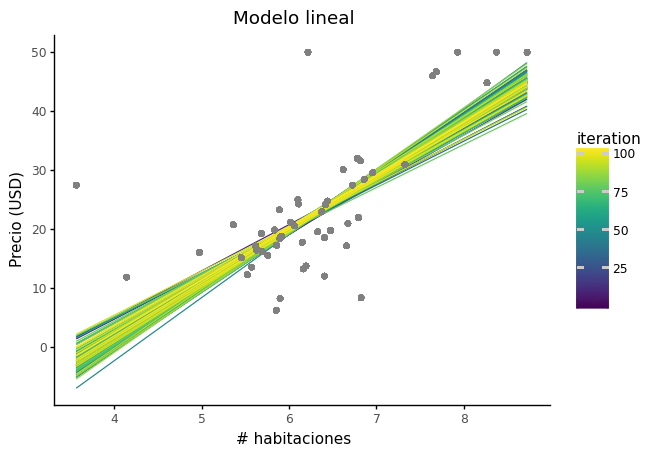

<ggplot: (345034271)>

In [96]:
# Graficar modelod lineales
gg = (ggplot() +
      geom_line(df_results, aes('RM','lr_pred', group = 'iteration', color = 'iteration')) +
      geom_point(df_results, aes('RM','MEDV'), color = 'grey') +
      labs(title = "Modelo lineal", y = "Precio (USD)", x = "# habitaciones") +
      theme_classic()
)
gg.save(filename=path_figs + 'predicciones_precios_casas_modelo_lineal.png')
gg

/Users/dantegruizmartinez/.pyenv/versions/3.8.0/envs/diplomado/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/dantegruizmartinez/.pyenv/versions/3.8.0/envs/diplomado/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figs/aprende/predicciones_precios_casas_modelo_random_forest.png


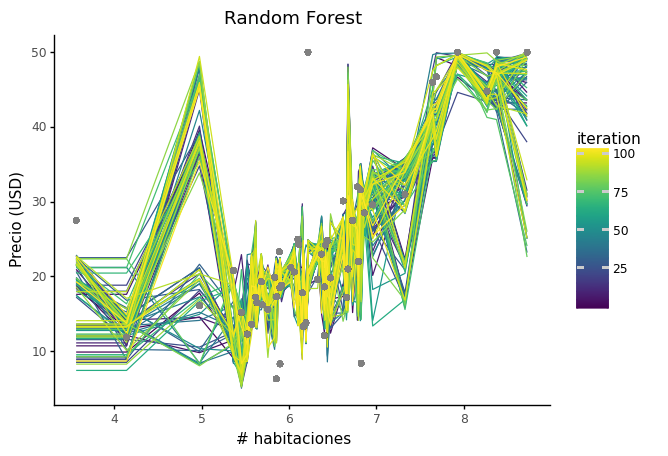

<ggplot: (341342998)>

In [97]:
# Graficar modelod de bosques aleatorios
gg = (ggplot() +
      geom_line(df_results, aes('RM','rf_pred', group = 'iteration', color = 'iteration'), ) +
      geom_point(df_results, aes('RM','MEDV'), color = 'grey') +
      labs(title = "Random Forest", y = "Precio (USD)", x = "# habitaciones") + 
      theme_classic()
)
gg.save(filename=path_figs + 'predicciones_precios_casas_modelo_random_forest.png')
gg

----------------------------

### Construcción de conjuntos de entrenamiento y prueba

In [98]:
from sklearn.model_selection import train_test_split

# Paso 1: Dividir el conjunto de entrenamiento y prueba
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, 
    test_size = .10,
    random_state=seed,
    shuffle = True # Construir los conjuntos utilizando aleatorización
)
# Paso 2: Dividir el conjunto de entrenamiento en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, 
    test_size = 51, 
    random_state=seed,
    shuffle = False, # Construir los conjuntos utilizando aleatorización
)

In [99]:
def print_dimensions(X_train, X_val, X_test, y_train, y_val, y_test):
    print("Dimensiones:\n")
    print(f"X_train: {X_train.shape}\ty_train: {y_train.shape}")
    print(f"X_val: {X_val.shape}\ty_val: {y_val.shape}")
    print(f"X_test: {X_test.shape}\ty_test: {y_test.shape}")
print_dimensions(X_train, X_val, X_test, y_train, y_val, y_test)

Dimensiones:

X_train: (404, 13)	y_train: (404,)
X_val: (51, 13)	y_val: (51,)
X_test: (51, 13)	y_test: (51,)


------------

### Validación cruzada

In [100]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
linear_reg = LinearRegression(normalize=True)
# Calcular error de validación cruzada
scores = cross_val_score(
    linear_reg,                           # Especificación del modelo 
    X_train,                              # X de entrenamiento
    y_train,                              # y de entrenamiento
    cv=10, # K-splits,
    scoring='neg_root_mean_squared_error' # Métrica de evaluación
)

In [101]:
scores

array([-4.26520974, -4.68069164, -4.23082072, -4.2175756 , -4.34416778,
       -2.9718743 , -4.29155554, -4.34475091, -8.89913395, -4.41850221])

In [102]:
# Imprimir errores de validación cruzada
def fun_print_cross_validation_error(scores):
    # Imprimir resultados del error de validación para cada split
    print("Error de entrenamiento (RMSE):")
    [print(f"- Split-{k}: {np.round(-1*error,2)}") for k, error in enumerate(scores) ]
    # Imprimir el error promedio y desviación estándar de validación cruzada
    print("\nCross validation error (RMSE):")
    print(f"- Error promedio: {np.round(np.mean(-1*scores),2)}")
    print(f"- Desviación estándar del error: {np.round(np.std(-1*scores),2)}")

fun_print_cross_validation_error(scores)

Error de entrenamiento (RMSE):
- Split-0: 4.27
- Split-1: 4.68
- Split-2: 4.23
- Split-3: 4.22
- Split-4: 4.34
- Split-5: 2.97
- Split-6: 4.29
- Split-7: 4.34
- Split-8: 8.9
- Split-9: 4.42

Cross validation error (RMSE):
- Error promedio: 4.67
- Desviación estándar del error: 1.47


In [103]:
from sklearn.metrics import mean_squared_error
# Imprimir error de predicción
def fun_print_error(X_train, X_test, y_train, y_test):
    linear_reg.fit(X_train, y_train)
    y_pred = linear_reg.predict(X_test)
    rmse = np.round(np.sqrt(mean_squared_error(y_test, y_pred)),2)
    print(f"- Error promedio (RMSE): {rmse}")
# Imprimir error en conjunto de validación
fun_print_error(
    X_train, 
    X_val, 
    y_train, 
    y_val
)

- Error promedio (RMSE): 6.21


In [104]:
# Imprimir el error en el conjunto de prueba
fun_print_error(
    X_train, 
    X_test, 
    y_train, 
    y_test
)

- Error promedio (RMSE): 3.94


--------

## Tema 2: Construcción de un flujo de trabajo para problemas de regresión
### Extracción y selección de variables


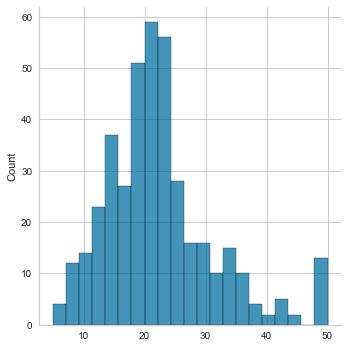

In [105]:
import seaborn as sns
sns.displot(y_train)

In [168]:
np.log(0 + 1)

0.0

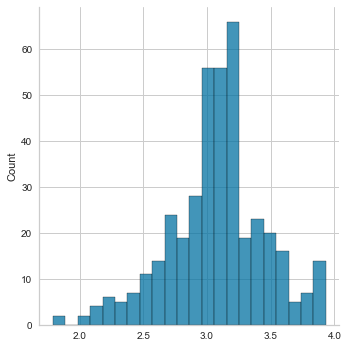

In [166]:
sns.displot(np.log(y_train + 1) )

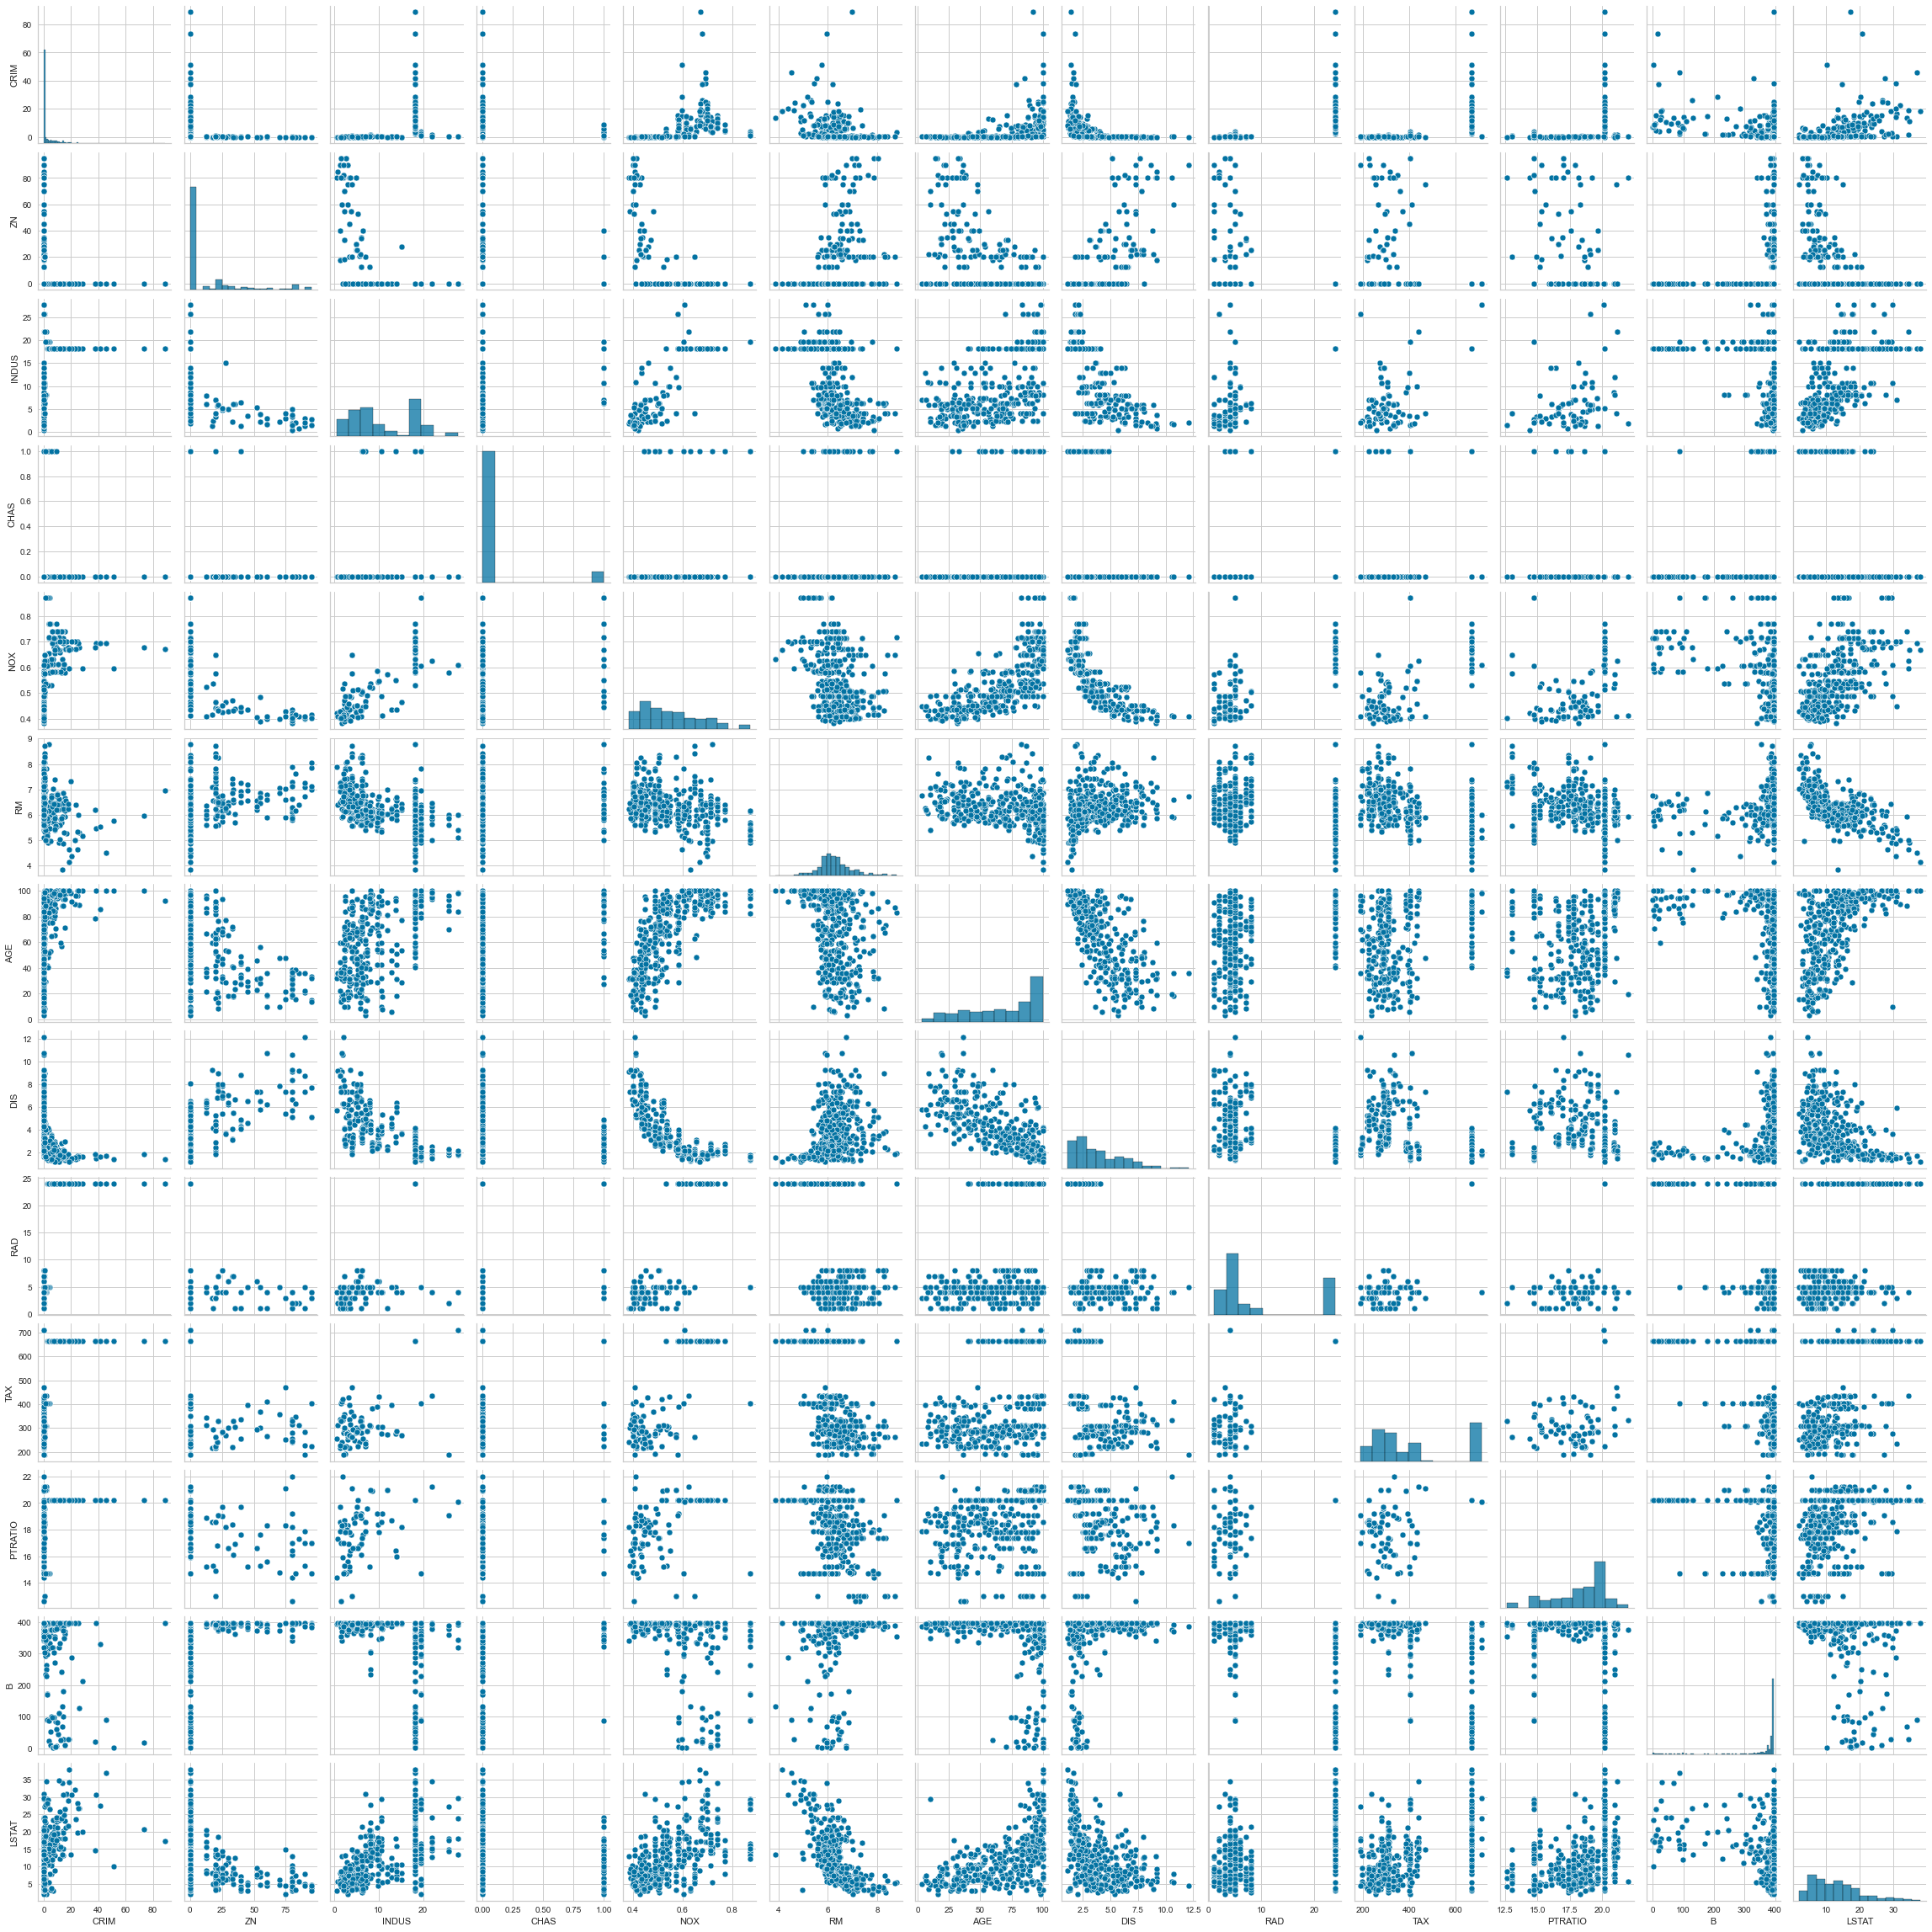

In [107]:
sns.pairplot(X_train)

In [108]:
X_train.melt().assign(log_value = lambda x : np.log(x.value + 1))

,variable,value,log_value
0,CRIM,0.08829,0.084608
1,CRIM,14.23620,2.723674
2,CRIM,0.54011,0.431854
3,CRIM,0.66351,0.508930
4,CRIM,0.33045,0.285517
...,...,...,...
5247,LSTAT,7.44000,2.132982
5248,LSTAT,3.16000,1.425515
5249,LSTAT,13.35000,2.663750
5250,LSTAT,8.61000,2.262804


In [109]:
np.log(0  + 1)

0.0

/Users/dantegruizmartinez/.pyenv/versions/3.8.0/envs/diplomado/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/dantegruizmartinez/.pyenv/versions/3.8.0/envs/diplomado/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figs/aprende/histograma_de_predictores.png


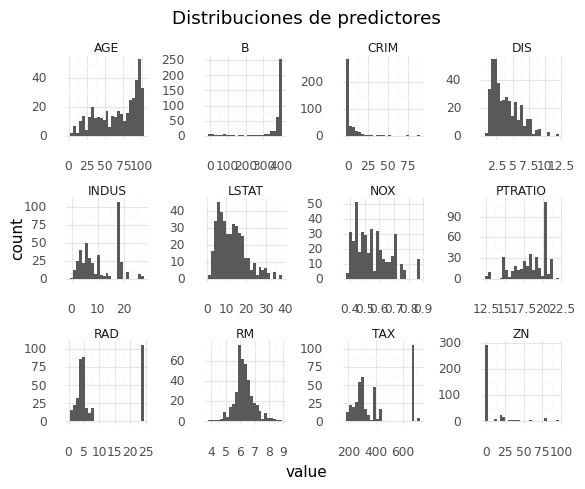

<ggplot: (347359229)>

In [110]:
X_train_long = (
    X_train
        .copy()
        .drop(columns = ['CHAS'], axis = 1)
        .melt()
        .assign(log_value = lambda x : np.log(x.value + 1))
)
gg = (ggplot(X_train_long, aes(x = 'value')) + 
 geom_histogram(bins = 25) + 
 facet_wrap('~variable', scales = 'free') +
 labs(title = "Distribuciones de predictores") +
 theme_minimal() +
 theme(subplots_adjust={'hspace': 0.7, 'wspace': 0.7})
)
gg.save(filename=path_figs + 'histograma_de_predictores.png')
gg

/Users/dantegruizmartinez/.pyenv/versions/3.8.0/envs/diplomado/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/dantegruizmartinez/.pyenv/versions/3.8.0/envs/diplomado/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figs/aprende/histograma_de_log_predictores.png


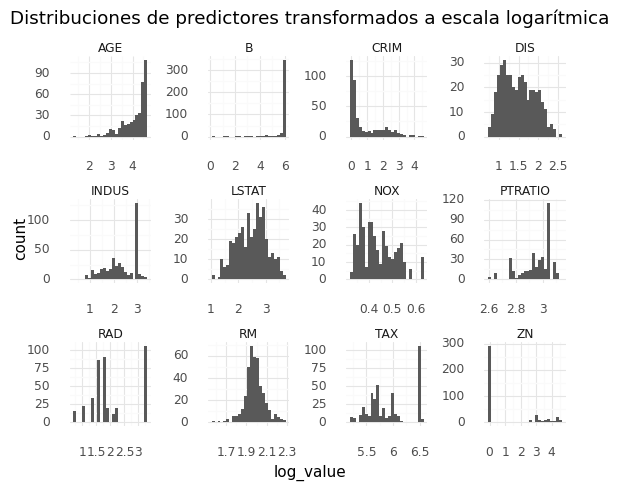

<ggplot: (348017652)>

In [111]:
gg = (ggplot(X_train_long, aes(x = 'log_value')) + 
 geom_histogram(bins = 25) + 
 facet_wrap('~variable', scales = 'free') +
 labs(title = "Distribuciones de predictores transformados a escala logarítmica") +
 theme_minimal() +
 theme(subplots_adjust={'hspace': 0.7, 'wspace': 0.7})

)
gg.save(filename=path_figs + 'histograma_de_log_predictores.png')
gg

**Convertir a escala logarítmica**

In [112]:
def fun_convert_data_to_log(X, y):
    vars_numeric = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS',
                    'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
    vars_dummy = ['CHAS']
    vars_sorted = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 
                   'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
    X = X.copy()
    y = y.copy()
    X_log = np.log(X.loc[:, vars_numeric] + 1)
    X_dummy = X.loc[:, vars_dummy]
    X_log = pd.concat([X_log, X_dummy], axis = 1).loc[: , vars_sorted]
    y_log = np.log(y + 1)
    return (X_log, y_log)

In [113]:
X_log, y_log = fun_convert_data_to_log(X, y)

In [114]:
# Paso 1: Dividir el conjunto de entrenamiento y prueba
X_train_full_log, X_test_log, y_train_full_log, y_test_log = train_test_split(
    X_log, y_log, 
    test_size = .10,
    random_state=seed,
    shuffle = True # Construir los conjuntos utilizando aleatorización
)
# Paso 2: Dividir el conjunto de entrenamiento en entrenamiento y validación
X_train_log, X_val_log, y_train_log, y_val_log = train_test_split(
    X_train_full_log, y_train_full_log, 
    test_size = 51, 
    random_state=seed,
    shuffle = False, # Construir los conjuntos utilizando aleatorización
)

In [115]:
# Modelo log base
fun_print_error(X_train_log, X_val_log, y_train_log, y_val_log)
fun_print_error(X_train_log, X_test_log, y_train_log, y_test_log)
print(f"- Error de validación (RMSE): {np.round(np.exp(0.2) - 1,4)}")
print(f"- Error de prueba (RMSE): {np.round(np.exp(0.18) - 1,4)}")

- Error promedio (RMSE): 0.2
- Error promedio (RMSE): 0.18
- Error de validación (RMSE): 0.2214
- Error de prueba (RMSE): 0.1972


* Vemos que hay una gran mejora en el error de validación y en el de prueba.

**Crear interacciones de las variables**

In [116]:
from sklearn.preprocessing import PolynomialFeatures
# Especificar cómo queremos las interacciones
poly = PolynomialFeatures(
    degree=2,
    interaction_only=True,
    include_bias = False
)
# Pasar los datos de entrenamiento
poly = poly.fit(X_train_log)
nombres_columnas = poly.get_feature_names()
# Construir los conjuntos de entrenamiento, validación y prueba con interacciones
X_train_log_poly = pd.DataFrame(poly.transform(X_train_log), columns = nombres_columnas)
X_val_log_poly = pd.DataFrame(poly.transform(X_val_log), columns = nombres_columnas)
X_test_log_poly = pd.DataFrame(poly.transform(X_test_log), columns = nombres_columnas)

In [117]:
X_train_log.shape

(404, 13)

In [118]:
X_train_log_poly

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x8 x9,x8 x10,x8 x11,x8 x12,x9 x10,x9 x11,x9 x12,x10 x11,x10 x12,x11 x12
0,0.084608,2.602690,2.182675,0.0,0.421338,1.947623,4.213608,1.881067,1.791759,5.743003,...,10.290080,4.990070,10.719968,4.654079,15.994328,34.359976,14.917399,16.662522,7.234042,15.540602
1,2.723674,0.000000,2.949688,0.0,0.526502,1.993747,4.615121,0.945500,3.218876,6.502790,...,20.931674,9.830451,19.268837,9.848619,19.859528,38.927006,19.896233,18.281864,9.344161,18.315653
2,0.431854,3.044522,1.603420,0.0,0.498955,2.104500,4.416428,1.135298,1.791759,5.579730,...,9.997534,4.728556,10.707274,4.228391,14.725227,33.343590,13.167661,15.770593,6.227938,14.102453
3,0.508930,3.044522,1.603420,0.0,0.498955,2.120224,4.615121,1.062847,1.791759,5.579730,...,9.997534,4.728556,10.663473,3.894595,14.725227,33.207190,12.128183,15.706079,5.736294,12.936045
4,0.285517,0.000000,1.974081,0.0,0.410121,1.958121,4.135167,1.537276,2.197225,5.730100,...,12.590316,6.399088,13.038842,5.437815,16.688060,34.003745,14.181174,17.282566,7.207649,14.686373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,0.147868,0.000000,2.068128,0.0,0.370183,1.975608,2.014903,1.905222,1.386294,5.455321,...,7.562681,4.074544,8.290109,2.956941,16.034072,32.623091,11.636103,17.576334,6.269180,12.755340
400,0.432107,3.044522,1.603420,0.0,0.454255,2.136531,3.981549,1.353771,1.791759,5.579730,...,9.997534,4.728556,10.695863,2.554180,14.725227,33.308055,7.953989,15.753786,3.762016,8.509576
401,0.105548,0.000000,3.358290,0.0,0.475613,1.943479,4.436752,1.134591,1.609438,6.568078,...,10.570914,4.907616,9.634418,4.287140,20.027863,39.317833,17.495717,18.253560,8.122501,15.945742
402,0.045604,4.394449,0.924259,0.0,0.339325,2.092728,3.627004,2.117339,1.098612,5.799093,...,6.370954,2.867455,6.452140,2.485945,15.136037,34.058017,13.122211,15.328915,5.906077,13.289428


In [119]:
# Imprimir dimensiones
print_dimensions(
    X_train_log_poly, X_val_log_poly, X_test_log_poly, 
    y_train_log, y_val_log, y_test_log
)

Dimensiones:

X_train: (404, 91)	y_train: (404,)
X_val: (51, 91)	y_val: (51,)
X_test: (51, 91)	y_test: (51,)


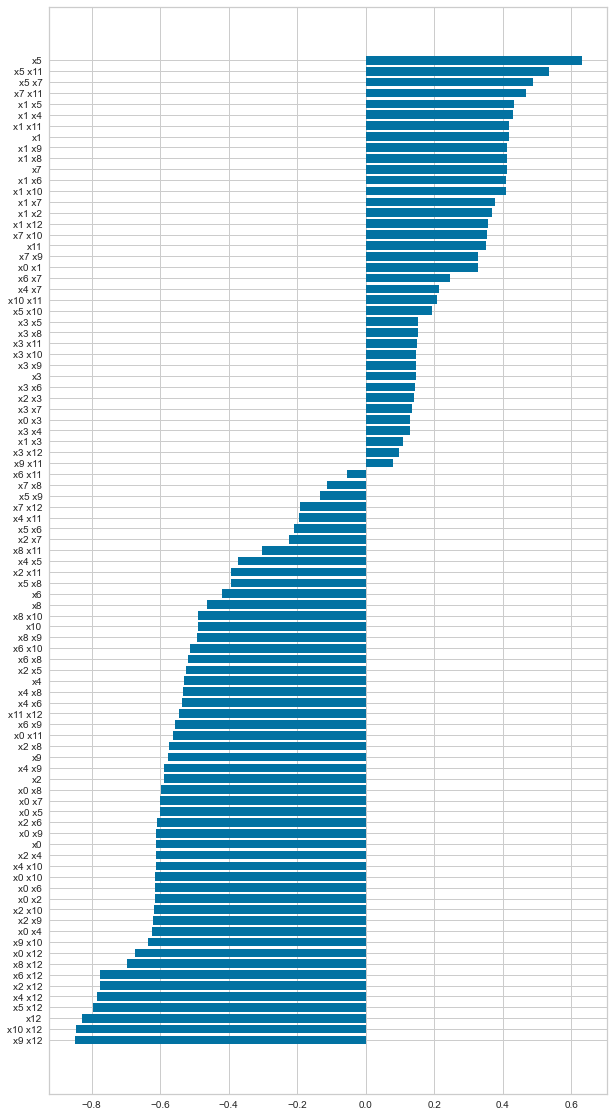

In [120]:
from yellowbrick.target import FeatureCorrelation
# Visualizar la correlación de las variables originales + sus interacciones
# con la variable dependiente

# Ajustar tamaño de la gráfica
fig, ax = plt.subplots(figsize=(10,20))
# Declarar el visualizador
visualizer = FeatureCorrelation(
    labels=nombres_columnas,     # Agregar el nombre de las variables
    sort = True                  # Ordenar correlaciones
)
visualizer.fit(X_train_log_poly, y_train_log)   # Pasar los datos de entrenamiento
visualizer                               # Visualizar
# Guardar imagen
fig.savefig(path_figs + "featrue_correlation.png")

In [121]:
# Modelo log base
fun_print_error(X_train_log_poly, X_val_log_poly, y_train_log, y_val_log)
fun_print_error(X_train_log_poly, X_test_log_poly, y_train_log, y_test_log)
print(f"- Error de validación (RMSE): {np.round(np.exp(0.22) - 1,2)}")
print(f"- Error de prueba (RMSE): {np.round(np.exp(0.15) - 1,2)}")

- Error promedio (RMSE): 0.22
- Error promedio (RMSE): 0.15
- Error de validación (RMSE): 0.25
- Error de prueba (RMSE): 0.16


* Vemos que tenemos desempeños muy similares.
* Las interacciones nos ayudaron a obtener el menor error en prueba, no en validación.
* Este es un ejemplo de como probar en varios conjuntos nos ayuda a tener conclusiones más sólidas

**Correlaciones de predictores**

<AxesSubplot:title={'center':'Pearson Ranking of 13 Features'}>

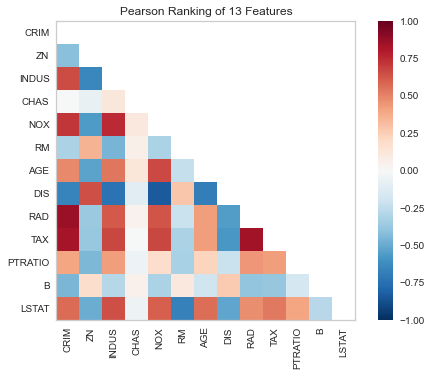

In [122]:
from yellowbrick.features import Rank2D

# Graficar las correlaciones de los predictores
visualizer = Rank2D(algorithm='pearson')
# Calcular correlaciones
visualizer = visualizer.fit(X_train_log, y_train_log)
visualizer.transform(X_train_log)
# Graficar
visualizer.show(outpath=path_figs + "matriz_de_correlaciones_predictores.png")

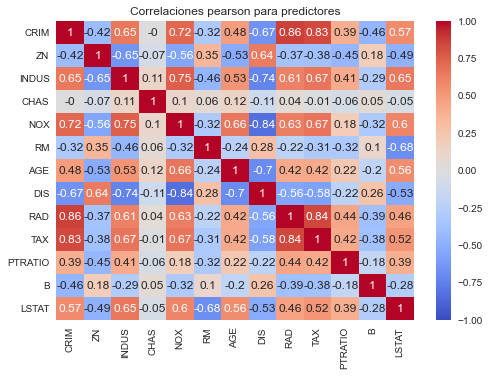

In [123]:
# Mapa de calor de correlaciones utilizando seaborn
(sns.heatmap(X_train_log.corr().round(2), 
             annot = True, 
             cmap = 'coolwarm', 
             vmin = -1, vmax = 1)
 .set_title('Correlaciones pearson para predictores')
)
plt.savefig(path_figs + 'matriz_de_correlaciones_predictores_con_seaborn.png')

**Recursive Feature Elimination**

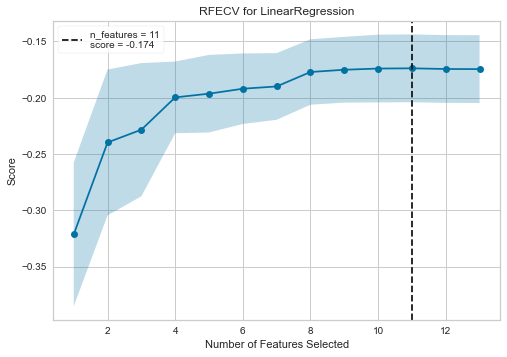

In [170]:
from yellowbrick.model_selection import RFECV
# Declarar el modelo 
visualizer = RFECV(
    # Pasar un modelo (estimator) 
    linear_reg,   
    # Escoger métrica de error
    scoring = 'neg_root_mean_squared_error',
    # Seleccionar k-folds de validación cruzada
    cv = 10                                    
)
# Pasar datos de entrenamiento
visualizer.fit(X_train_log, y_train_log)    
# Graficar 
visualizer.show(path_figs + "recursive_feature_elimination.png");                     

In [171]:
# Extraemos las variables seleccionadas
seleccion_de_variables = visualizer.support_

In [173]:
X_train_log.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')

In [172]:
seleccion_de_variables

array([ True, False,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True])

In [176]:
X_train_log.columns[seleccion_de_variables]

Index(['CRIM', 'INDUS', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO',
       'B', 'LSTAT'],
      dtype='object')

In [174]:
# Variables no seleccionadas
print(list(X_train_log.loc[: ,np.bitwise_not(seleccion_de_variables) ].columns))

['ZN', 'AGE']


In [127]:
# Modelo con selección de variables por el método RFECV
fun_print_error(X_train_log.loc[:, seleccion_de_variables], X_val_log.loc[:, seleccion_de_variables], y_train_log, y_val_log)
fun_print_error(X_train_log.loc[:, seleccion_de_variables], X_test_log.loc[:, seleccion_de_variables], y_train_log, y_test_log)
print(f"- Error de validación (RMSE): {np.round(np.exp(0.22) - 1,2)}")
print(f"- Error de prueba (RMSE): {np.round(np.exp(0.15) - 1,2)}")

- Error promedio (RMSE): 0.2
- Error promedio (RMSE): 0.18
- Error de validación (RMSE): 0.25
- Error de prueba (RMSE): 0.16


* Con este método el modelo log log selecciona algunas variables.
* En desempeño del error no hay diferencia entre el modelo en log log y el normal.

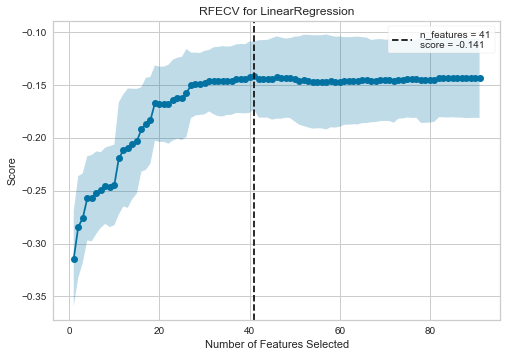

In [128]:
# Declarar el modelo 
visualizer = RFECV(
    # Pasar un modelo (estimator) 
    linear_reg,   
    # Escoger métrica de error
    scoring = 'neg_root_mean_squared_error',
    # Seleccionar k-folds de validación cruzada
    cv = 10                                    
)
visualizer.fit(X_train_log_poly, y_train_log)
# Graficar
visualizer.show(path_figs + "recursive_feature_elimination_con_interacciones.png");

In [129]:
# Extraemos las variables seleccionadas
seleccion_de_variables = visualizer.support_

# Modelo con selección de variables por el método RFECV
fun_print_error(X_train_log_poly.loc[:, seleccion_de_variables], X_val_log_poly.loc[:, seleccion_de_variables], y_train_log, y_val_log)
fun_print_error(X_train_log_poly.loc[:, seleccion_de_variables], X_test_log_poly.loc[:, seleccion_de_variables], y_train_log, y_test_log)
print(f"- Error de validación (RMSE): {np.round(np.exp(0.21) - 1,2)}")
print(f"- Error de prueba (RMSE): {np.round(np.exp(0.15) - 1,2)}")

- Error promedio (RMSE): 0.21
- Error promedio (RMSE): 0.15
- Error de validación (RMSE): 0.23
- Error de prueba (RMSE): 0.16


https://github.com/parrt/random-forest-importances

### Regularización L1 y L2


#### Ridge L1

In [130]:
from sklearn.linear_model import Ridge
# Especificar un modelo Ridge
ridge = Ridge(
    alpha=1,          # Fijar lambda
    normalize = True  # Normalizar datos media = 0, sd = 1
)
# Pasar datos de entrenamiento
ridge.fit(X_train_log, y_train_log)
# Predecir en validación
y_log_pred = ridge.predict(X_val_log)
# Calcular RMSE
log_rmse = np.sqrt(mean_squared_error(y_val_log, y_log_pred))
rmse = np.round(np.exp(log_rmse) - 1,4)
print(f"- Error promedio de validación (RMSE): {rmse}")
# Predecir en prueba
y_log_pred = ridge.predict(X_test_log)
# Calcular RMSE
log_rmse = np.sqrt(mean_squared_error(y_test_log, y_log_pred))
rmse = np.round(np.exp(log_rmse) - 1,4)
print(f"- Error promedio de prueba (RMSE): {rmse}")

- Error promedio de validación (RMSE): 0.3253
- Error promedio de prueba (RMSE): 0.2621


In [131]:
# Graficar coeficientes de regularización ridge
def plot_coef_regularization(model, lambdas, X_train, y_train, coef_names = "", title = ""):
    '''Regresa una gráfica con los coeficientes para distintos modelos de 
    regresión ridge utilizando lambdas diferentes.
    
    En sklearn la regresión ridge la lambda de regularización está 
    paremetrizada como alpha. Pero es la misma especificación.

    Parameters
    ----------
    model: Modelo ridge o lasso.
    lambdas: Array de lambdas de regularización.
    X_train: Conjunto de entrenamiento estandarizado.
    y_train: Variable dependiente del entrenamiento
    coef_names: List con los nombres de los coeficientes.

    Returns
    -------
    Gráfica de los coeficientes en función de la lambda de 
    regularización.
    '''   
    # Ajustar modelos y extraer coeficientes
    coefs = []
    for a in lambdas: 
        model.set_params(**{'alpha':a})
        model.fit(X_train, y_train)
        coefs.append(model.coef_)
    # Convertir coeficientes en un dataframe
    df_coefs = pd.DataFrame(coefs, columns=coef_names)
    df_coefs['lambda'] = lambdas
    # Graficar lambdas
    plot = df_coefs.plot(
        x = 'lambda',
        title = title,
        ylabel = 'coeficientes',
        xlabel = 'lambda',
        logx = True,
        figsize = (12, 6),
        grid=True
    ).legend(loc='upper right')
    # Guardar la imagen en un archivo
    fig = plot.get_figure()
    fig.savefig(path_figs + f"coef_regularization_{type(model).__name__}.png")

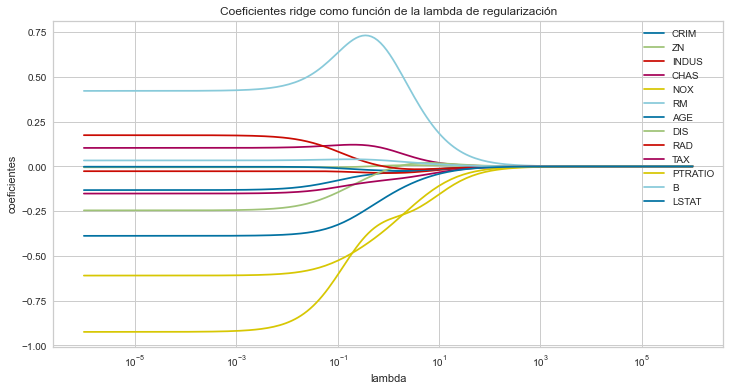

In [132]:
# Crear un conjunto de 100 lambdas igualmente espaciadas.    
n_lambdas = 200
lambdas = np.logspace(-6, 6, n_lambdas)
# Especificar un modelo Ridge
ridge = Ridge(normalize = True)
# Ajustar n modelos ridge
plot_coef_regularization(
    ridge, lambdas, 
    X_train_log, y_train_log, 
    coef_names = X_train_log.columns,
    title = 'Coeficientes ridge como función de la lambda de regularización'
)

In [133]:
from sklearn.linear_model import RidgeCV
# Crear n lambdas
n_lambdas = 200
lambdas = np.logspace(-6, 6, n_lambdas)
# Crear validación cruzada para un modelo Ridge 
model = RidgeCV(
    alphas=lambdas,                           # Fijar lambdas
    normalize=True,                           # Estandarizar valores en media 0 y sd 1
    scoring = 'neg_root_mean_squared_error',  # Fijar medida de error
    cv = 10                                   # Fijar k-folds de validación cruzada
)
# Ajustar n modelos
model.fit(X_train_log, y_train_log)
# Extraer la lambda que da el menor error promedio de validación cruzada
print(f"Mejor lambda: {np.round(model.alpha_,4)}")
print(f"Error promedio de validación cruzada (RMSE): {np.round(np.exp(-1*model.best_score_) - 1,4)}")

Mejor lambda: 0.011
Error promedio de validación cruzada (RMSE): 0.1905


In [134]:
# Ajustar n modelos con 91 predictores
model.fit(X_train_log_poly, y_train_log)
# Extraer la lambda que da el menor error promedio de validación cruzada
print(f"Mejor lambda: {np.round(model.alpha_,4)}")
print(f"Error promedio de validación cruzada (RMSE): {np.round(np.exp(-1*model.best_score_) - 1,4)}")

Mejor lambda: 0.0
Error promedio de validación cruzada (RMSE): 0.1472


In [135]:
from sklearn.metrics import mean_squared_error
def plot_validation_error_vs_ridge_regularization(model, lambdas, X_train, y_train, cv, exp = False):
    '''Regresa una gráfica con el error de validación RMSE como función del parámetro
    de regularización Ridge.
    
    En sklearn, la regresión ridge la lambda de regularización está 
    paremetrizada como alpha. Pero es la misma especificación.

    Parameters
    ----------
    model: Modelo ridge.
    lambdas: Array de lambdas de regularización.
    X_train: Conjunto de entrenamiento estandarizado.
    y_train: Variable dependiente del entrenamiento
    cv: Int o Array con índices para hacer la validación (tscv). 

    Returns
    -------
    Gráfica con los errores de validación como función de la regularización.
    '''  
    # Ajustar varios modelos Ridge
    errors = []
    for lam in lambdas:
        scores = cross_val_score(
            model.set_params(**{'alpha':lam}),
            X_train,
            y_train,
            cv=cv,
            scoring='neg_root_mean_squared_error'
        )
        mean_score = -1*np.mean(scores)
        errors.append(mean_score)
    if exp:
        errors = np.exp(errors) - 1 
    # Convertir los resultados en un dataframe
    df_results = pd.DataFrame({'lambda': lambdas, 'error': errors})
    # Graficar el error vs la regularización
    plot = df_results.plot(        
        x = 'lambda',
        title = 'Error de validación cruzada (RMSE) como función del parámetro lambda de regularización Ridge',
        ylabel = 'Promedio del error de validación cruzada (RMSE)',
        xlabel = 'lambda',
        logx = True,
        figsize = (12, 6),
        color = 'black',
        grid=True
    )
    # Agregar una línea vertical en el valor mínimo de error
    lambda_optim = df_results.iloc[df_results.error.idxmin(), :]['lambda']
    plt.axvline(
        x = lambda_optim, 
        linestyle='dashed', 
        color = 'red',
        label = 'lambda'
    );
    # Guardar figura
    fig = plot.get_figure()
    fig.savefig(path_figs + f"error_regularization_{type(model).__name__}.png")

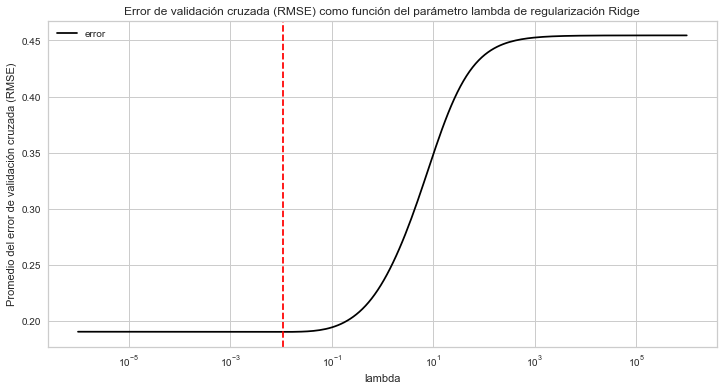

In [136]:
lambdas = np.logspace(-6, 6, n_lambdas)
model = Ridge(normalize = True)
plot_validation_error_vs_ridge_regularization(
    model, 
    lambdas, 
    X_train_log,
    y_train_log, 
    cv = 10,
    exp = True
)

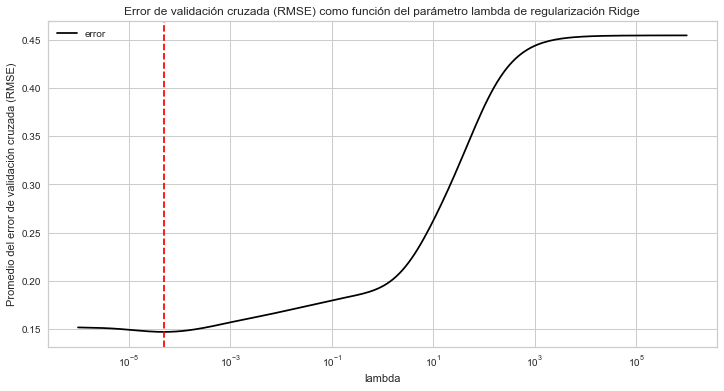

In [137]:
lambdas = np.logspace(-6, 6, n_lambdas)
model = Ridge(normalize = True)
plot_validation_error_vs_ridge_regularization(
    model, 
    lambdas, 
    X_train_log_poly,
    y_train_log, 
    cv = 10,
    exp = True
)

#### Lasso L2

In [138]:
from sklearn.linear_model import Lasso
# Especificar un modelo Ridge
lasso = Lasso(
    alpha=1,          # Fijar lambda
    normalize = True  # Normalizar datos media = 0, sd = 1
)
# Pasar datos de entrenamiento
lasso.fit(X_train_log, y_train_log)
# Predecir en validación
y_log_pred = lasso.predict(X_val_log)
# Calcular RMSE
log_rmse = np.sqrt(mean_squared_error(y_val_log, y_log_pred))
rmse = np.round(np.exp(log_rmse) - 1,4)
print(f"- Error promedio de validación (RMSE): {rmse}")
# Predecir en prueba
y_log_pred = lasso.predict(X_test_log)
# Calcular RMSE
log_rmse = np.sqrt(mean_squared_error(y_test_log, y_log_pred))
rmse = np.round(np.exp(log_rmse) - 1,4)
print(f"- Error promedio de prueba (RMSE): {rmse}")

- Error promedio de validación (RMSE): 0.561
- Error promedio de prueba (RMSE): 0.4688


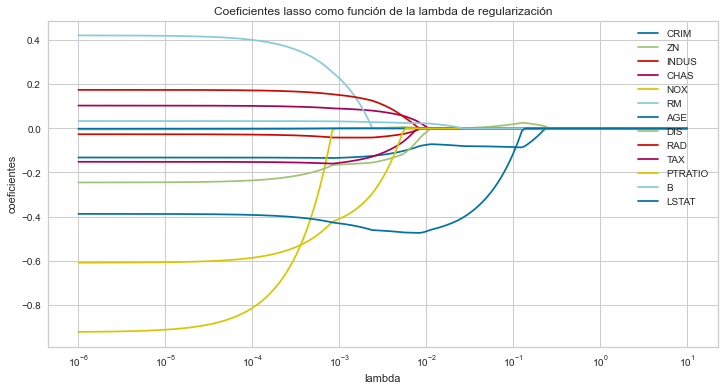

In [139]:
n_lambdas = 200
lambdas = np.logspace(-6, 1, n_lambdas)
lasso = Lasso(fit_intercept=True, max_iter=3000)
plot_coef_regularization(
    lasso, lambdas, 
    X_train_log, y_train_log, 
    coef_names = X_train_log.columns,
    title = 'Coeficientes lasso como función de la lambda de regularización'
)

In [140]:
from sklearn.linear_model import LassoCV

def plot_validation_error_vs_lasso_regularization(model, lambdas, X_train, y_train, exp=False):
    '''Regresa una gráfica con el error de validación RMSE como función del parámetro
    de regularización Lasso.
    
    En sklearn, la regresión ridge la lambda de regularización está 
    paremetrizada como alpha. Pero es la misma especificación.

    Parameters
    ----------
    model: Modelo lasso.
    lambdas: Array de lambdas de regularización.
    X_train: Conjunto de entrenamiento estandarizado.
    y_train: Variable dependiente del entrenamiento

    Returns
    -------
    Gráfica con los errores de validación como función de la regularización.
    '''  
    # Ajustar modelo y extraer resultados
    model.fit(X_train, y_train)
    
    errors = np.sqrt(model.mse_path_)
    if exp:
        errors = np.exp(errors) - 1 
    
    df_results = pd.concat([
            pd.DataFrame(model.alphas, columns=['lambda']), 
            pd.DataFrame(errors).mean( axis = 1).rename('rmse')
        ], 
        axis = 1
    )
    # Identificar la lambda que minimiza el RMSE
    best_results = df_results.iloc[df_results.rmse.idxmin()]
    lambda_optim = best_results['lambda']
    print(f"Mejor lambda: {np.round(lambda_optim,4)}")
    print(f"Promedio del error de validación cruzada (RMSE): {np.round(best_results['rmse'],2)}")
    # Graficar el error vs la regularización.
    plot = df_results.plot(
        x = 'lambda', y = 'rmse',
        title = 'Error de validación RMSE como función del parámetro lambda de regularización Lasso',
        ylabel = 'cross_val_error', xlabel = 'lambda',
        logx = True,
        figsize = (12, 6),
        color = 'black',
        grid = True
    )
    # Graficar lambda óptima
    plt.axvline(
        x = lambda_optim, 
        linestyle='dashed', 
        color = 'red',
        label = 'lambda'
    );
    # Guardar la figura
    fig = plot.get_figure()
    fig.savefig(path_figs + f"error_regularization_{type(model).__name__}.png")

# Crear n lambdas para probar el modelo Lasso 
n_lambdas = 200
lambdas = np.logspace(-6, 1, n_lambdas)
# Evaluar las lambdas con validación cruzada 
model = LassoCV(
    alphas=lambdas,
    cv = 10,
    max_iter=3000,
    random_state=seed
)


Mejor lambda: 0.2833
Promedio del error de validación cruzada (RMSE): 0.19


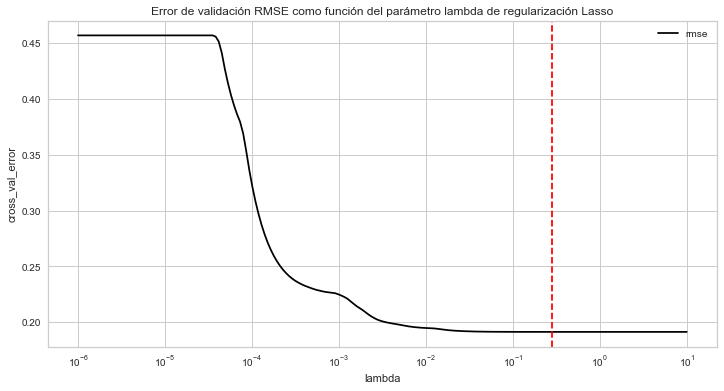

In [141]:
plot_validation_error_vs_lasso_regularization(
    model, 
    lambdas, 
    X_train_log, 
    y_train_log, 
    exp = True
)

In [142]:
# Ajustar mejores modelos al conjunto de validación
def fun_models_predict(models, X_train, X_test, y_train, y_test, col_names, exp = False):
    '''Función para construir predicciones de varios modelos.
    La función regresa los siguientes resultados.
    - Errores de prueba de todos los modelos
    - Coeficientes de todos los modelos
    - Predicciones de todos los modelos
    
    Parameters
    ----------
    models: (List) Lista con modelos para predecir. 
    X_train: (DataFrame o Array) Conjunto de entrenamiento, idealmente estandarizado. 
    X_test: (DataFrame o Array) Conjunto de prueba, idealmente estandarizado.  
    y_train: (DataFrame o Array) Variable de respuesta del conjunto de entrenamiento. 
    y_test: (DataFrame o Array) Variable de respuesta del conjunto de prueba.
    col_names: Lista con el nombre de las variables del modelo.

    Returns
    -------
    Regresa un tuple con tres elementos.
    df_test_errors: (DataFrame) Errores de prueba de todos los modelos, 
    df_coef: (DataFrame) Coeficientes de todos los modelos.
    df_predictions: (DataFrame) Predicciones de todos los modelos.
    
    ''' 
    # Inicializar diccionarios
    test_errors = {}
    coefs = {}
    predictions = {}
    # Ajustar modelos
    for model in models:
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        predictions[type(model).__name__] = pred
        # Recuperar coeficientes
        coefs[type(model).__name__] = model.coef_
        # Calcular errores de prueba RMSE
        rmse = np.sqrt(mean_squared_error(y_test, pred))
        if exp:
            rmse = np.exp(rmse) - 1  
        test_errors[type(model).__name__] = rmse
    predictions['medv'] = y_test
    coefs['Coeficiente'] = col_names
    # Construir un dataframe con los errores de prueba de todos los modelos
   
    df_test_errors = (
        pd.Series(test_errors)
            .sort_values(ascending = True)
        .round(4)
        .to_frame()
        .rename(columns = {0:'mean_rmse'})
    )
    # Construir un dataframe con los coeficientes de todos los modelos
    df_coef = (
        pd.DataFrame(coefs)
            .loc[:, ['Coeficiente', 'LinearRegression', 'Ridge', 'Lasso']]
            .round(4)
    )
    # Construir un dataframe con las predicciones de los modelos.
    df_predictions = (
        pd.DataFrame(predictions)
            .round(1)
            .loc[:, ['medv', 'LinearRegression', 'Ridge', 'Lasso']]
    )
    
    return (df_test_errors, df_coef, df_predictions)

In [143]:
n_lambdas = 200
lambdas = np.logspace(-6, 6, n_lambdas)
ridge_cv = RidgeCV(lambdas, normalize = True, scoring = 'neg_root_mean_squared_error', cv = 10)
ridge_cv.fit(X_train_log, y_train_log)
best_ridge_lambda = ridge_cv.alpha_
best_ridge_lambda

n_lambdas = 200
lambdas = np.logspace(-6, 6, n_lambdas)
lasso_cv = LassoCV(alphas = lambdas, normalize = True)
lasso_cv.fit(X_train_log, y_train_log)
best_lasso_lambda = lasso_cv.alpha_
best_lasso_lambda

lreg = LinearRegression()
lridge = Ridge(alpha=best_ridge_lambda, normalize=True)
llasso = Lasso(alpha=best_lasso_lambda, normalize=True)
models = [lreg,lridge, llasso]

variable_names = X_train_log.columns
df_val_errors, df_coef, df_predictions = fun_models_predict(
    models,
    X_train_log, 
    X_val_log, 
    y_train_log, 
    y_val_log, 
    col_names = variable_names,
    exp = True
)

df_test_errors, df_coef, df_predictions = fun_models_predict(
    models,
    X_train_log, 
    X_test_log, 
    y_train_log, 
    y_test_log, 
    col_names = variable_names,
    exp = True
)

In [144]:
# Errores en el conjunto de validación y de prueba
df_errores = pd.concat([df_val_errors, df_test_errors], axis = 1)
df_errores.columns = ['Error Validación', 'Error Prueba']
df_errores.sort_values(by = 'Error Prueba')

,Error Validación,Error Prueba
Lasso,0.2268,0.2012
LinearRegression,0.2269,0.2013
Ridge,0.2291,0.2022


In [145]:
def style_negative(v, props=''):
    '''Función para colorear los valores negativos en rojo'''
    return props if v < 0 else None
(df_coef
     .set_index('Coeficiente')
     # Aplicar estilos a la tabla
     .style
         # Colorear de rojo los coeficientes negativos
         .applymap(style_negative, props='color:red;')
         # Colorear de gris los coeficientes en cero
         .applymap(lambda v: 'opacity: 20%;' if (v < 0.0001) and (v > -0.0001) else None)
)

,LinearRegression,Ridge,Lasso
Coeficiente,,,
CRIM,-0.132300,-0.121500,-0.129900
ZN,-0.004900,-0.005200,-0.004400
INDUS,-0.026600,-0.026400,-0.024700
CHAS,0.103300,0.106400,0.102600
NOX,-0.924500,-0.869200,-0.899600
RM,0.421800,0.458800,0.422300
AGE,-0.001600,-0.002500,-0.000000
DIS,-0.245600,-0.227400,-0.239000
RAD,0.174600,0.157500,0.169800


* Vemos que la regularización óptima es poca, por lo que los errores entre el modelo lineal y los regularizados son practicamente iguales.
* Sin embargo, observar que la regularización que se aplicó efectivamente encoge los coeficientes.
* En el caso del modelo lasso, la variable AGE es reducida a un coeficiente de cero. Por lo que el modelo quitó esta variable.
* Puedes intentar esto con el conjunto con interacciones, pero dado que tenemos pocas observaciones y muchas columnas al modelo lasso le cuesta mucho converger.

---------

## Tema: Evaluación de modelos de regresión y selección del mejor

### Gráfica de errores vs predicción, histograma de errores y gráfica de real vs ajustado

In [146]:
df_predictions.head()

,medv,LinearRegression,Ridge,Lasso
0,3.5,3.6,3.6,3.6
1,3.0,3.0,3.0,3.0
2,3.3,3.1,3.1,3.1
3,3.2,3.2,3.2,3.2
4,3.0,3.2,3.2,3.2


In [147]:
# Convertir las predicciones en formato long y calcular errores.
df_predictions_long = (
    df_predictions
        .melt(id_vars=['medv'], var_name=['model'], value_name='pred_medv')
        .assign(error = lambda x: x.medv - x.pred_medv)
        .assign(model = lambda x: pd.Categorical(x.model, categories = ['LinearRegression', 'Ridge', 'Lasso'], ordered=True))
        .loc[:, ['model', 'medv', 'pred_medv', 'error']]
)
df_predictions_long

,model,medv,pred_medv,error
0,LinearRegression,3.5,3.6,-0.1
1,LinearRegression,3.0,3.0,0.0
2,LinearRegression,3.3,3.1,0.2
3,LinearRegression,3.2,3.2,0.0
4,LinearRegression,3.0,3.2,-0.2
...,...,...,...,...
148,Lasso,3.1,3.0,0.1
149,Lasso,3.4,3.4,0.0
150,Lasso,3.1,3.2,-0.1
151,Lasso,3.9,3.8,0.1


**Histograma de errores**

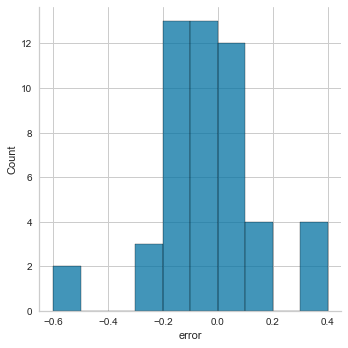

In [148]:
# Graficar histograma de errores
df_lasso_results = df_predictions_long.loc[df_predictions_long.model == 'Lasso', :]
sns.displot(df_lasso_results, x = 'error')
plt.savefig(path_figs + 'histograma_residuales.png');

**Predicciones vs Actuales**

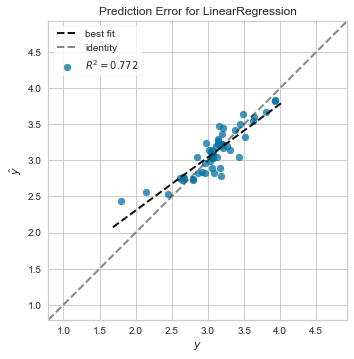

In [149]:
from yellowbrick.regressor import PredictionError
visualizer = PredictionError(lreg)
visualizer.fit(X_train_log, y_train_log)  # Fit the training data to the visualizer
visualizer.score(X_test_log, y_test_log)  # Evaluate the model on the test data
visualizer.show();  


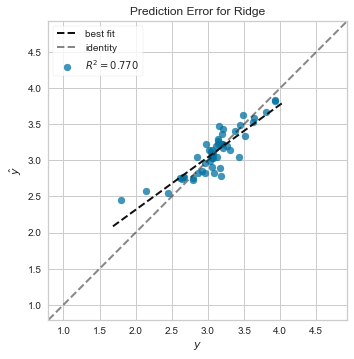

In [150]:
visualizer = PredictionError(lridge)
visualizer.fit(X_train_log, y_train_log)  # Fit the training data to the visualizer
visualizer.score(X_test_log, y_test_log)  # Evaluate the model on the test data
visualizer.show();  

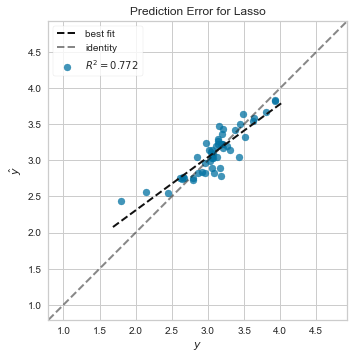

In [151]:
visualizer = PredictionError(llasso)
visualizer.fit(X_train_log, y_train_log)  # Fit the training data to the visualizer
visualizer.score(X_test_log, y_test_log)  # Evaluate the model on the test data
visualizer.show(outpath=path_figs + 'ajuste_vs_valores_reales.png'); 

**Residuales vs Ajuste**

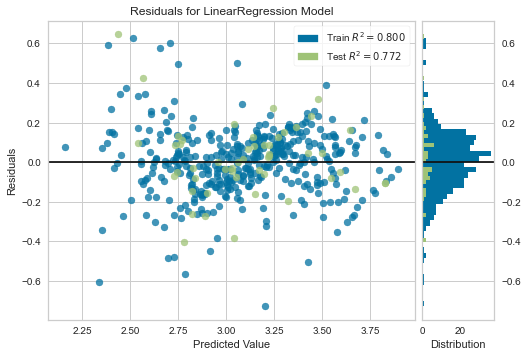

In [152]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(lreg)
visualizer.fit(X_train_log, y_train_log)  # Fit the training data to the visualizer
visualizer.score(X_test_log, y_test_log)  # Evaluate the model on the test data
visualizer.show();  

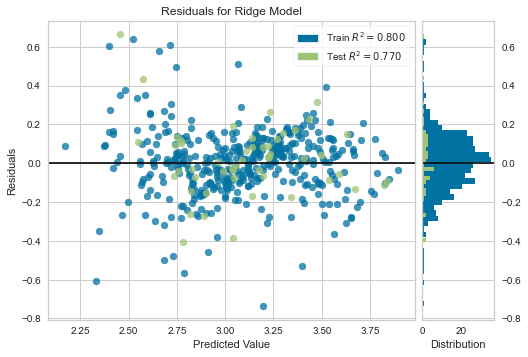

In [153]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(lridge)
visualizer.fit(X_train_log, y_train_log)  # Fit the training data to the visualizer
visualizer.score(X_test_log, y_test_log)  # Evaluate the model on the test data
visualizer.show();  

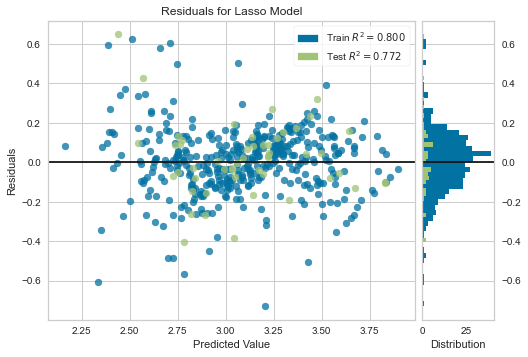

In [154]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(llasso)
visualizer.fit(X_train_log, y_train_log)  # Fit the training data to the visualizer
visualizer.score(X_test_log, y_test_log)  # Evaluate the model on the test data
visualizer.show(path_figs + 'errores_vs_predicciones');

-------

### Selección de hiperparámetros

In [155]:
%%time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor(random_state = seed)

parameters = {
    'n_estimators':np.arange(100, 250, 10), 
    'max_depth' : np.arange(7, 12, 1),
    'min_samples_split': np.arange(2, 4, 1)
}
grid_search = GridSearchCV(
    rf, 
    parameters, 
    n_jobs=-1, 
    return_train_score=True, 
    scoring='neg_root_mean_squared_error',
    cv=10
)
grid_search.fit(X_train_log, y_train_log)
y_pred_val = grid_search.predict(X_val_log)
y_pred_test = grid_search.predict(X_test_log)

CPU times: user 4.09 s, sys: 448 ms, total: 4.54 s
Wall time: 2min 43s


In [156]:
grid_search.best_estimator_

RandomForestRegressor(max_depth=11, n_estimators=190, random_state=20210719)

In [157]:
grid_search.best_params_

{'max_depth': 11, 'min_samples_split': 2, 'n_estimators': 190}

In [158]:
# Recupearar los resultados de la validación cruzada
def fun_plot_grid_search_results(df):   
    '''Regresa un DataFrame con los resultados de la exploración de hiperparámetros.

    Esta función muestra una tabla estilizada con los resultados de la exploración de
    hiper parámetros utilizando validación cruzada.
    
    En la tabla aparecen del lado izquierdo la combinación de hiperparámetros, el error
    de entrenamiento y el error de validación cruzada y el ranking del mejor modelo
    a partir del error de validación.
    
    El mapa de color va de azul (modelos con menor error) a rojo (modelos con mayor error).
    Se calcula para el error de entrenamiento y validación de manera separada.
    
    Los resultados están ordenados de mejor a peor modelo, en función del error de validación.
    
    Parameters
    ----------
    dict: Diccionario con los resultados de la búsqueda de hiperparámetros GridSearchCV.cv_results_ 
        
    Returns
    -------
    pandas.io.formats.style.Styler
        Regresa una tabla estilizada con los resultados de la búsqueda de hiperparámetros.
    '''
    # Elegir paleta divergente de colores
    cm = sns.diverging_palette(250, 5, as_cmap=True)
    
    return (
        pd.concat([
            # Limpiar la columna de parámetros
            df['params'].apply(pd.Series), 
            # Extraer solamente el error de prueba 
            df[['mean_train_score', 'mean_test_score', 'rank_test_score']]],
            axis = 1
        )
        .assign(
            mean_train_score = lambda x: np.exp(-1* x.mean_train_score) - 1,
            mean_test_score = lambda x: np.exp(-1 * x.mean_test_score) - 1
        )
        # Ordenar los modelos de mejor a peor
        .sort_values(by = 'rank_test_score')
        # Pintar el fondo de la celda a partir del error de validación
        .style.background_gradient(cmap=cm, subset = ['mean_train_score', 'mean_test_score'])
    )

df_best_params = pd.DataFrame(grid_search.cv_results_)
tabla_resultados = fun_plot_grid_search_results(df_best_params)
tabla_resultados

,max_depth,min_samples_split,n_estimators,mean_train_score,mean_test_score,rank_test_score
129,11,2,190,0.059481,0.160403,1
130,11,2,200,0.059364,0.160488,2
134,11,2,240,0.059680,0.160501,3
128,11,2,180,0.059594,0.160528,4
133,11,2,230,0.059852,0.160552,5
131,11,2,210,0.059501,0.160554,6
132,11,2,220,0.059704,0.160586,7
125,11,2,150,0.059764,0.160648,8
127,11,2,170,0.059603,0.160710,9
124,11,2,140,0.059866,0.160725,10


In [159]:
error_val = np.exp(np.sqrt(mean_squared_error(y_val_log, y_pred_val))) - 1
error_pred = np.exp(np.sqrt(mean_squared_error(y_test_log, y_pred_test))) - 1

print(f"Error validación (RMSE): {np.round(error_val,2)}")
print(f"Error prueba (RMSE): {np.round(error_pred,2)}")

Error validación (RMSE): 0.14
Error prueba (RMSE): 0.13


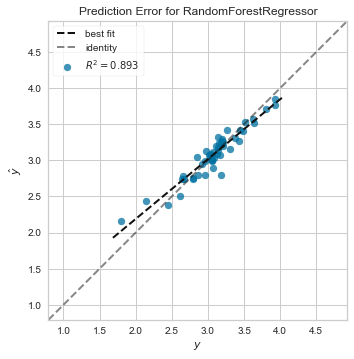

In [160]:
from yellowbrick.regressor import PredictionError
visualizer = PredictionError(grid_search.best_estimator_)
visualizer.fit(X_train_log, y_train_log)  # Fit the training data to the visualizer
visualizer.score(X_test_log, y_test_log)  # Evaluate the model on the test data
visualizer.show(path_figs + 'ajuste_vs_valores_reales_random_forest.png'); 

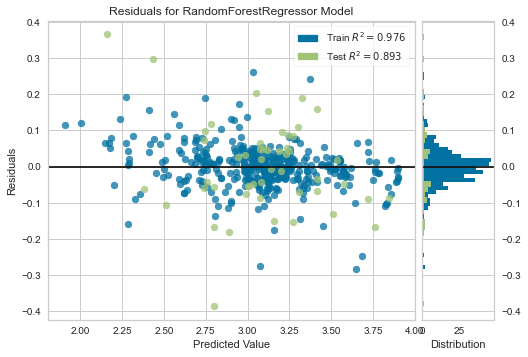

In [161]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(grid_search.best_estimator_)
visualizer.fit(X_train_log, y_train_log)  # Fit the training data to the visualizer
visualizer.score(X_test_log, y_test_log)  # Evaluate the model on the test data
visualizer.show(path_figs + 'errores_vs_predicciones_random_forest.png');

In [162]:
%%time
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor(random_state = seed)

parameters = {
    'n_estimators':np.arange(100, 250, 10), 
    'max_depth' : np.arange(7, 12, 1),
    'min_samples_split': np.arange(2, 4, 1)
}
random_grid_search = RandomizedSearchCV(
    rf, 
    parameters, 
    n_iter = 10,
    n_jobs=-1, 
    return_train_score=True, 
    scoring='neg_root_mean_squared_error',
    cv=10
)
random_grid_search.fit(X_train_log, y_train_log)
y_pred_val = random_grid_search.predict(X_val_log)
y_pred_test = random_grid_search.predict(X_test_log)

CPU times: user 830 ms, sys: 36.6 ms, total: 867 ms
Wall time: 12 s


In [163]:
random_grid_search.best_params_

{'n_estimators': 180, 'min_samples_split': 2, 'max_depth': 11}

In [164]:
error_val = np.exp(np.sqrt(mean_squared_error(y_val_log, y_pred_val))) - 1
error_pred = np.exp(np.sqrt(mean_squared_error(y_test_log, y_pred_test))) - 1

print(f"Error validación (RMSE): {np.round(error_val,2)}")
print(f"Error prueba (RMSE): {np.round(error_pred,2)}")

Error validación (RMSE): 0.14
Error prueba (RMSE): 0.13


In [165]:
# Recupearar los resultados de la validación cruzada
df_best_params = pd.DataFrame(random_grid_search.cv_results_)
tabla_resultados = fun_plot_grid_search_results(df_best_params)
tabla_resultados

,n_estimators,min_samples_split,max_depth,mean_train_score,mean_test_score,rank_test_score
9,180,2,11,0.059594,0.160528,1
0,170,2,10,0.060880,0.161075,2
2,230,2,9,0.063751,0.161370,3
4,230,3,10,0.063633,0.161533,4
7,240,3,8,0.070027,0.161796,5
5,130,3,11,0.062875,0.162039,6
6,160,3,9,0.065760,0.162220,7
1,120,2,10,0.061843,0.162272,8
8,200,2,7,0.075438,0.163431,9
3,150,3,7,0.077124,0.163478,10
